# Topic Modeling for App Reviews
### Natural Language Processing (NLP) Project — Korean Financial Mobile Applications
*Author: Yongjun (Andrew) Lee, KSFC

This notebook demonstrates an end-to-end Korean natural language processing (NLP) pipeline that performs **topic modeling** on mobile app user reviews using **Latent Dirichlet Allocation (LDA)**.  
It aims to extract meaningful insights from user feedback to guide **UX improvement** and **service innovation** in digital banking platforms.

In [1]:
import warnings, logging, sys, os

# 1. Suppress all Python-level DeprecationWarnings globally
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 2. Disable noisy loggers commonly triggered inside Jupyter/Colab
logging.getLogger("asyncio").setLevel(logging.ERROR)
logging.getLogger("tornado").setLevel(logging.ERROR)
logging.getLogger("jupyter_client").setLevel(logging.ERROR)

# 3. Redirect stderr to /dev/null to silence residual warnings
sys.stderr = open(os.devnull, "w")

# 4. Explicitly ignore the specific datetime.utcnow() deprecation warning
warnings.filterwarnings(
    "ignore",
    message="datetime.datetime.utcnow() is deprecated",
    category=DeprecationWarning
)

print("✅ Deprecation warnings (utcnow) completely suppressed.")

✅ Deprecation warnings (utcnow) completely suppressed.


In [2]:
# Install all required dependencies
!pip install --upgrade pip
!pip install "scipy<1.13"  # rollback to compatible version
!pip install pandas numpy matplotlib
!pip install konlpy
!pip install gensim==4.3.2
!pip install pyLDAvis==3.4.1
!pip install openpyxl  # for reading Excel files
!pip install JPype1  # required for KoNLPy (Java bridge)

In [3]:
import pandas as pd
import numpy as np
import html

import re
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"

from datetime import datetime
from pprint import pprint

from konlpy.tag import Komoran
import gensim, pyLDAvis
print("OK:", gensim.__version__, pyLDAvis.__version__)

from gensim.models import Word2Vec, LdaModel, TfidfModel,CoherenceModel
from gensim.corpora import Dictionary

import pyLDAvis.gensim_models as gensimvis  # correct import for pyLDAvis 3.x

import matplotlib.pyplot as plt

OK: 4.3.2 3.4.0


## 1. Data Cleaning and Normalization
This section cleans raw text from mobile app user reviews by:
- Removing HTML entities and URLs  
- Normalizing spacing, casing, and symbols  
- Standardizing domain-specific terminology (e.g., “공동인증서” → “Digital Certificate”)  

In [4]:
def display_features(features, feature_names):
    df = pd.DataFrame(data=features, columns=feature_names)
    print(df)

def get_sentences( text ) :
    # 0. Restore HTML entities
    text = html.unescape(text)

    # 1. Remove URLs
    sentences = re.sub(r"https?://\S+|www\.\S+", " ", text)

    # 2. Replace remaining control characters after HTML unescape
    sentences = re.sub(r'[\t\r\f\n]+', ' ', sentences)

    # 3. Keep only English, Korean, digits, and spaces
    sentences = re.sub(r'[^A-Za-z0-9가-힣 ]', ' ', sentences)

    # 4. Normalize whitespace
    sentences = re.sub(r'\s+', ' ', sentences).strip()

    # 5. Convert to uppercase
    sentences = sentences.upper()

    # 6. Apply domain-specific replacements (using negative lookahead to avoid over-replacement)
    replace_patterns = [
        # Digital certificate PKI
        (r'공인\s*인증\s*서',  '공동인증서'),
        (r'공동\s*인증\s*서',  '공동인증서'),
        (r'금융\s*인증\s*서',  '금융인증서'),

        # Replace "... 인증" → standard form (exclude if followed by "서")
        (r'공인\s*인증(?!서)',  '공동인증서'),
        (r'공동\s*인증(?!서)',  '공동인증서'),
        (r'금융\s*인증(?!서)',  '금융인증서'),

        (r'간편\s*비밀번호',   '간편인증'),
        (r'패턴\s*인증',       '간편인증'),
        (r'바이오\s*인증',     '바이오인증'),
        (r'지문\s*인증',       '바이오인증'),
        (r'얼굴\s*인증',       '바이오인증'),
        (r'본인\s*인증',       '본인인증'),
        (r'본인\s*확인',       '본인인증'),
        (r'계좌\s*인증',       '계좌인증'),
        (r'1원\s*인증',       '계좌인증'),

        #(r'주민\s*등록증',     '신분증'),
        #(r'운전\s*면허증',     '신분증'),

        (r'비번',              '비밀번호'),

        # Case-insensitive English normalization
        (r'(?i:\bID\b)',       'ID'),
        (r'(?i:\bPW\b)',       '비밀번호'),
        (r'(?i:\bUI\b)',       'UI'),
        (r'(?i:\bUX\b)',       'UX'),
        (r'어플|애플리케이션|에플리케이션|(?i:\bAPP\b)', '앱'),

        (r'한국\s*증권\s*금융|한국\s*금융\s*증권|증권\s*금융|증금', '한국증권금융'),
        (r'튕기', '튕김'),
        (r'공공\s*기관',  '공공기관'),
        (r'타\s*기관',  '타기관'),
        (r'고객\s*정보',  '고객정보'),

        # Word-boundary protection using lookaround
        (r'(?<![가-힣A-Za-z0-9])우리\s*사주(?![가-힣A-Za-z0-9])', '우리사주'),
        (r'(?<![가-힣A-Za-z0-9])비대면\s*가입(?![가-힣A-Za-z0-9])', '가입'),
        (r'(?<![가-힣A-Za-z0-9])회원\s*가입(?![가-힣A-Za-z0-9])',   '가입'),
        (r'(?<![가-힣A-Za-z0-9])상품\s*가입(?![가-힣A-Za-z0-9])',   '가입'),
        (r'(?<![가-힣A-Za-z0-9])주민\s*등록증(?![가-힣A-Za-z0-9])', '신분증'),
        (r'(?<![가-힣A-Za-z0-9])운전\s*면허증(?![가-힣A-Za-z0-9])', '신분증'),

        (r'우리사주\s*뱅킹', '우리사주뱅킹'),
        (r'사주\s*뱅킹',    '우리사주뱅킹'),
        (r'인터넷\s*뱅킹',  '인터넷뱅킹'),
        (r'모바일\s*뱅킹',  '모바일뱅킹'),

        (r'슈레기|쉬레기임|쉬레기|RUBBISH|쓰래기', '쓰레기'),
        (r'에러', '오류'),
    ]

    # Apply compiled replacement patterns sequentially
    for patt, repl in replace_patterns:
        sentences = re.sub(patt, repl, sentences)

    return sentences

# Extract POS tags from Komoran
def get_pos_tags(komoran, docs):
    morph_list = []
    for sentence in docs:
        s = sentence.strip()
        if not s:
            continue
        try:
            morph_list.append(komoran.pos(s))
        except Exception as e:
            print('error : ', s)
    return morph_list


# Extract Korean common and proper nouns (NNG, NNP)
def get_NNG_NNP_words(morphs_list, stop_words_list=None):
    if stop_words_list is None:
        stop_words_list = set()
    NNG_NNP_words = []
    for morphs in morphs_list:
        item = []
        for word, tag in morphs:
            if tag in ('NNG', 'NNP'):
                if len(word) <= 1 or word.isnumeric():   # 항상 길이 필터 적용
                    continue
                if word in stop_words_list:
                    continue
                item.append(word)
        NNG_NNP_words.append(item)
    return NNG_NNP_words


# 1) Domain-specific compound noun dictionary (final forms only)
TERM_TO_TAG = {
    "인증서": "NNG",
    "인증센터": "NNG",
    "공동인증서": "NNP",
    "금융인증서": "NNG",
    "간편인증": "NNG",
    "바이오인증": "NNG",
    "본인인증": "NNG",
    "신분증": "NNG",
    "운전면허증": "NNP",
    "주민등록증": "NNP",
    "한국증권금융": "NNP",
    "우리사주": "NNG",
    "계좌인증": "NNG",
    "1원인증": "NNG",
    "인터넷뱅킹": "NNG",
    "우리사주뱅킹": "NNG",
    "모바일뱅킹": "NNG",
    "파킹통장": "NNG",
    "무결성": "NNG",
    "리뉴얼": "NNG",
    "로그인": "NNG",
    "비밀번호":"NNG",
    "버퍼링":"NNG",
    "비대면":"NNG",
    #"회원가입":"NNG",
    #"상품가입":"NNG",
    "가입":"NNG",
    "공공기관":"NNG",
    "금융기관":"NNG",
    "타기관":"NNG",
    "고객정보":"NNG",

    "재설치":"NNG",
    "재시도": "NNG",

    "UI":"NNG",
    "UX":"NNG",
    "ID": "NNG"
}

# Normalize candidate tokens (fix spacing or Jamo issues)
def _normalize_candidate(cand: str) -> str:

    cand = cand.replace(" ", "")
    cand = cand.replace("이ㄴ", "인")
    cand = cand.replace("비대이면", "비대면")
    cand = cand.replace("로그인창", "로그인창")
    cand = cand.replace("로그인", "로그인")
    cand = cand.replace("버퍼링", "버퍼링")
    cand = cand.replace("비밀번호", "비밀번호")
    cand = cand.replace("아이디", "ID")
    return cand

# Combine tokens into a surface form without spaces
def _join_surface(tokens):
    return ''.join(w.replace(' ', '') for w, _ in tokens)

# List of Korean postpositions (from longest to shortest)
JOSA = ["으로써","으로서","으로","으로는","에게서","에게","에서","에는","에는",
        "까지","부터","라도","라도","라도","라고","처럼","만큼",
        "에게","에게는","에게도","보다","보다도",
        "이라고","이라고는","이란","이랑","으로도",
        "이가","이는","이도","이를","으로서","으로써",
        "이가","은","는","이","가","을","를","과","와","도","만","에","의"]

def split_na_with_josa(token):
    """ Split tokens ending with postpositions, e.g., ('앱이','NA') → [('앱','NNG'), ('이','JKS')] """
    w, t = token
    if t != "NA":
        return [token]

    # Match longest postpositions first
    for js in sorted(JOSA, key=len, reverse=True):
        if w.endswith(js) and len(w) > len(js):
            stem = w[:-len(js)]
            # '앱'같은 도메인 stem 리태깅
            if stem == "앱":
                stem_tag = "NNG"
            else:
                stem_tag = "NNG"  # 기본값
            # 조사 품사 대략 매핑
            josa_tag = "JKS" if js in ["이","가"] else \
                       "JKO" if js in ["을","를"] else \
                       "JX"  if js in ["은","는","도","만"] else \
                       "JKB" if js in ["에","에서","에게","으로","로","까지","부터","처럼","만큼","보다"] else \
                       "JC"  if js in ["과","와"] else "JX"
            return [(stem, stem_tag), (js, josa_tag)]
    return [token]

# -------- Global configuration (to avoid re-creation on every call) --------
SMALL_GLUE = {
    ("로","그","인"): "로그인",
    ("버","퍼","링"): "버퍼링",
    ("비","밀","번","호"): "비밀번호",
    ("아","이","디"): "아이디",
    ("로그","인"): "로그인",
    ("버퍼","링"): "버퍼링",
    ("비","밀","번호"): "비밀번호",

    ("공공","기관"): "공공기관",
    ("금융","기관"): "금융기관",
    ("타","기관"): "타기관",

    ("재","설치"): "재설치",
    ("재","시도"): "재시도",

    # Extend as needed
    ("로그","인창"): "로그인창",
    ("로그","인후"): "로그인후",
}

def merge_compound_terms(pos_seq, term_to_tag=TERM_TO_TAG, max_len=5):
    """
    Merge or correct compound terms within POS-tagged sequences.
    e.g., [('공동','NNG'), ('이','VCP'), ('ㄴ','ETM'), ('증서','NNP')] → [('공동인증서','NNP')]
    """
    merged = []
    i, n = 0, len(pos_seq)

    while i < n:
        found = False

        # 1) 1) Apply small glue rules first (up to 4 tokens)
        for L in range(min(4, n - i), 2, -1):
            chunk = tuple(w for w, _ in pos_seq[i:i+L])
            if chunk in SMALL_GLUE:
                glued = SMALL_GLUE[chunk]
                glued_norm = _normalize_candidate(glued)
                tag = term_to_tag.get(glued_norm, "NNG")
                merged.append((glued_norm, tag))
                i += L
                found = True
                break
        if found:
            continue

        # 2) Domain-specific compound word dictionary (up to max_len tokens)
        for L in range(min(max_len, n - i), 1, -1):
            window = pos_seq[i:i+L]
            cand = _join_surface(window)
            cand = _normalize_candidate(cand)
            if cand in term_to_tag:
                merged.append((cand, term_to_tag[cand]))
                i += L
                found = True
                break
        if found:
            continue

        # 3) Default: keep current token (handle NA + postposition splitting)
        w, t = pos_seq[i]
        w_norm = w.replace(' ', '')

        # If token type is "NA", split it by postposition (e.g., '앱이' → [('앱','NNG'),('이','JKS')])
        parts = split_na_with_josa((w_norm, t)) if t == "NA" else [(w_norm, t)]

        for pw, pt in parts:
            # Force consistent tagging for domain-specific terms like '앱'
            if pw == "앱" and pt in ("NA", "NNP", "NNG"):
                merged.append(("앱", "NNG"))
            else:
                merged.append((pw, pt))

        i += 1

    return merged

In [5]:
# ----------------------------------------------------
# [1] Configuration (Reusable by only modifying file paths & key parameters)
# ----------------------------------------------------
EXCEL_PATH      = '/content/drive/MyDrive/Data_Colab/all_reviews.xlsx'
STOP_WORDS_PATH = '/content/drive/MyDrive/Data_Colab/stop_words_list.txt'
DICTIONARY_PATH = '/content/drive/MyDrive/Data_Colab/dictionary.txt'
DATA_PATH       = '/content/drive/MyDrive/Data_Colab/'
RESULT_PATH       = '/content/drive/MyDrive/Result_Colab/'
SHEET_NAME   = 'Sheet1'
TEXT_COL     = 'content'            # Column name containing review text
NUM_TOPICS   = 3                    # Number of topics (recommended: 3 or 4)
NO_BELOW     = 5                    # Minimum term frequency threshold
NUM_WORDS    = 10                   # Number of representative words per topic
PASSES       = 10                   # Number of LDA training iterations
RANDOM_STATE = 42                   # Random seed for reproducibility
USE_MULTICORE = False               # Set True for large datasets to enable multi-core processing


# ----------------------------------------------------
# [2] Data Loading
# ----------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')  # Click “Allow” when prompted

df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
         date          author  \
0  2025-08-27             훈승채   
1  2025-08-25  CHANG YOUP LEE   
2  2025-08-25             정연균   
3  2025-08-25    Chunghui Lee   
4  2025-07-31             이영송   

                                             content  rating        store  
0                                 너무 편리하고 좋은 것 같습니다.       5  Google Play  
1                                                좋아요       5  Google Play  
2                                                좋아요       5  Google Play  
3                                         잘 쓰고 있습니다.       5  Google Play  
4  개정되고 편의성이 높아졌습니다! 상품 주요 정보도 한 눈에 보이고, 주사용 메뉴도 ...       5  Google Play  


In [6]:
# =====================
# [3] Load Stopword List
# =====================
with open(STOP_WORDS_PATH, 'r', encoding='utf-8') as f:
    stop_words_set = { line.strip() for line in f if line.strip() }

# Preview (show 10 sorted examples)
print(sorted(list(stop_words_set))[:10])
print("총 불용어 수:", len(stop_words_set))

['가요', '간만', '개도', '건지', '사람', '사용', '시간', '실행', '아무', '업데이트']
총 불용어 수: 23


In [7]:
# =====================
# [4] Cleasing words
# =====================
my_data_list=list()

for sentence in df[TEXT_COL].fillna('') :
    # Clean each review sentence using the get_sentences() function
    my_data_list.append(get_sentences(sentence))
my_data_list[:100]

['너무 편리하고 좋은 것 같습니다',
 '좋아요',
 '좋아요',
 '잘 쓰고 있습니다',
 '개정되고 편의성이 높아졌습니다 상품 주요 정보도 한 눈에 보이고 주사용 메뉴도 첫화면에 노출되니 쓰기 편하고 좋습니다',
 '원활하게 비대면 가입을 할 수 있어서 감사합니다',
 '별점 한개도 아깝습니다 앱 다시 만드세요 신분증 인증 40회만에 인증 성공 매번 이동 시 로그인 필수고 계좌인증 시 계좌 앱 인증번호 확인 후 증권사 앱 들어가면 무한 버퍼링 결국 앱 종료 밑에 글도 버퍼링이 심하다는 내용이 있는데 개선좀 해주세요',
 '무결성 검증실패',
 '과거에 비해서 많이 좋아졌내요 시중 금융권 앱과 비교되는 부분이 많았는데 디자인적으로나 기능적으로나 편하게 사용할 수 있어서 좋습니다 수고하세요',
 '도대체 신분증 어케등록함 30분내내 찍어올려도인증이안되네',
 '보기가 편하고 편리합니다',
 '파킹통장 금리가 좋네요',
 '생각보다 좋은거 같네요 잘 사용해보겠습니다',
 '리뉴얼되고 나서 더 편하고 나아졌어요',
 '최고네요',
 '대출 신상품 좋네요 앱도 좋아졌고',
 '시스템 개편이후 서비스가 넘 좋아졌습니다 굿 입니다요',
 '개편후 사용자 편의성이 너무 좋습니다 VERY VERY GOOD입니다',
 '훨씬 좋아졌어요 앱 계속 쓰고 있는데 아주 만족해요',
 '한국증권금융앱이 달라졌네요 전보다 훨씬 직관적인거 같아 좋습니다',
 '비밀번호를 몰라서 임시비밀번호로 로그인했는데 이전비밀번호를 넣어야한다는데 어떻게 해야하나요',
 '쓸 때마다 업데이트하라고 나오니깐 너무 짜증납니다 너무 자주 업데이트하지 마세요 꼭 필요한 것만 모아서 한 번에 해주셨으면 좋겠습니다',
 '여러 메뉴들이 잘 정리되어 있어서 편리한듯',
 '잘쓰고 있씁뉘다',
 '금리가 좋아서 자주 이용하고 있는데 최근 화면이나 편의성이 많이 개선되어서 사용하기 좋네요',
 'UI가 보기 편하고 도움이 됩니다',
 '사용하기 좋은 앱입니다',
 '앱 관리좀 합시다',
 '가끔 들어가는데 디자인이 

In [8]:
try:
    from kornounextractor.noun_extractor import extract
    korean_noun_set = set()
    for content in my_data_list:
        # Use the preprocessed version for cleaner input
        clean = get_sentences(content)
        # The extract() function can take raw text,
        # but using the cleaned version helps reduce noise.
        nouns = extract(clean, freq=2)
        if nouns:
            korean_noun_set.update(nouns)

    # Remove irrelevant or noisy tokens
    for junk in ("CO", "HTTPS", "HTTP"):
        if junk in korean_noun_set:
            korean_noun_set.discard(junk)
except Exception:
    korean_noun_set = set()

print(korean_noun_set)

set()


In [9]:
# NNG: General noun (common noun)
# NNP: Proper noun (named entity)

os.makedirs(os.path.dirname(DICTIONARY_PATH), exist_ok=True)

with open(DICTIONARY_PATH, 'w', encoding='utf8') as f:
    for word in sorted(korean_noun_set):
        f.write(f"{word}\tNNG\n")

    # Add domain-specific financial terms and standard forms
    # Note: Only standardized terms are included.
    # For example, “공인인증서” is unified as “공동인증서” during preprocessing,
    # so both are not required in the dictionary.
    add_dic = [
        ("고객정보","NNG"), ("공동인증서","NNP"), ("금융인증서","NNG"),
        ("간편인증","NNG"), ("바이오인증","NNG"), ("본인인증","NNG"),
        ("운전면허증","NNP"), ("주민등록증","NNP"), ("한국증권금융","NNP"),
        ("우리사주","NNG"), ("계좌인증","NNG"), ("1원인증","NNG"),
        ("계좌번호","NNG"), ("버퍼링","NNG"), ("인터넷뱅킹","NNG"),
        ("우리사주뱅킹","NNG"), ("모바일뱅킹","NNG"), ("파킹통장","NNG"),
        ("편의성","NNG"), ("비대면","NNG"), ("리뉴얼","NNG"),
        ("무결성","NNG"), ("로그인","NNG"), ("인증서","NNG"),
        ("인증센터","NNG"),
        ("가입","NNG"), #("회원가입","NNG"), ("상품가입","NNG"),
        ("공공기관","NNG"), ("금융기관","NNG"), ("타기관","NNG"),
        ("재설치","NNG"), ("재시도","NNG"),
        ("UI","NNG"), ("UX","NNG")
    ]

    # Write additional dictionary entries
    for w, t in add_dic:
        f.write(f"{w}\t{t}\n")

In [10]:
komoran = Komoran(userdic=DICTIONARY_PATH)

# Clean sentences using custom regex-based normalization
# Converts HTML entities, removes URLs/symbols, and unifies domain terminology
cleaned_docs = [get_sentences(x) for x in my_data_list]
print(cleaned_docs[:100])

['너무 편리하고 좋은 것 같습니다', '좋아요', '좋아요', '잘 쓰고 있습니다', '개정되고 편의성이 높아졌습니다 상품 주요 정보도 한 눈에 보이고 주사용 메뉴도 첫화면에 노출되니 쓰기 편하고 좋습니다', '원활하게 비대면 가입을 할 수 있어서 감사합니다', '별점 한개도 아깝습니다 앱 다시 만드세요 신분증 인증 40회만에 인증 성공 매번 이동 시 로그인 필수고 계좌인증 시 계좌 앱 인증번호 확인 후 증권사 앱 들어가면 무한 버퍼링 결국 앱 종료 밑에 글도 버퍼링이 심하다는 내용이 있는데 개선좀 해주세요', '무결성 검증실패', '과거에 비해서 많이 좋아졌내요 시중 금융권 앱과 비교되는 부분이 많았는데 디자인적으로나 기능적으로나 편하게 사용할 수 있어서 좋습니다 수고하세요', '도대체 신분증 어케등록함 30분내내 찍어올려도인증이안되네', '보기가 편하고 편리합니다', '파킹통장 금리가 좋네요', '생각보다 좋은거 같네요 잘 사용해보겠습니다', '리뉴얼되고 나서 더 편하고 나아졌어요', '최고네요', '대출 신상품 좋네요 앱도 좋아졌고', '시스템 개편이후 서비스가 넘 좋아졌습니다 굿 입니다요', '개편후 사용자 편의성이 너무 좋습니다 VERY VERY GOOD입니다', '훨씬 좋아졌어요 앱 계속 쓰고 있는데 아주 만족해요', '한국증권금융앱이 달라졌네요 전보다 훨씬 직관적인거 같아 좋습니다', '비밀번호를 몰라서 임시비밀번호로 로그인했는데 이전비밀번호를 넣어야한다는데 어떻게 해야하나요', '쓸 때마다 업데이트하라고 나오니깐 너무 짜증납니다 너무 자주 업데이트하지 마세요 꼭 필요한 것만 모아서 한 번에 해주셨으면 좋겠습니다', '여러 메뉴들이 잘 정리되어 있어서 편리한듯', '잘쓰고 있씁뉘다', '금리가 좋아서 자주 이용하고 있는데 최근 화면이나 편의성이 많이 개선되어서 사용하기 좋네요', 'UI가 보기 편하고 도움이 됩니다', '사용하기 좋은 앱입니다', '앱 관리좀 합시다', '가끔 들어가는데 디자인이 깔끔해졌네요', '앱이 훨씬 세련되고 안정적으로 개

## 2. Morphological Analysis and Compound Term Merging
Korean text requires morphological analysis to identify meaningful tokens.
We use **Komoran**, a Korean POS tagger, to extract nouns (NNG/NNP).  
Domain-specific compound terms such as "모바일뱅킹" or "본인인증" are manually merged to preserve semantics.

In [11]:
# Apply Komoran POS tagging to extract part-of-speech information
morphs_list = get_pos_tags(komoran, cleaned_docs)

# Merge domain-specific compound terms for better topic coherence
morphs_list = [merge_compound_terms(seq) for seq in morphs_list]

print(morphs_list[:100])

[[('너무', 'MAG'), ('편리', 'NNG'), ('하', 'XSV'), ('고', 'EC'), ('좋', 'VA'), ('은', 'ETM'), ('것', 'NNB'), ('같', 'VA'), ('습니다', 'EC')], [('좋', 'VA'), ('아요', 'EC')], [('좋', 'VA'), ('아요', 'EC')], [('잘', 'MAG'), ('쓰', 'VV'), ('고', 'EC'), ('있', 'VV'), ('습니다', 'EC')], [('개정', 'NNG'), ('되', 'XSV'), ('고', 'EC'), ('편의성', 'NNG'), ('이', 'JKS'), ('높', 'VA'), ('아', 'EC'), ('지', 'VX'), ('었', 'EP'), ('습니다', 'EC'), ('상품', 'NNG'), ('주요', 'XR'), ('정보', 'NNG'), ('도', 'JX'), ('한', 'MM'), ('눈', 'NNG'), ('에', 'JKB'), ('보이', 'VV'), ('고', 'EC'), ('주사', 'NNG'), ('용', 'XSN'), ('메뉴', 'NNP'), ('도', 'JX'), ('첫', 'MM'), ('화면', 'NNG'), ('에', 'JKB'), ('노출', 'NNG'), ('되', 'XSV'), ('니', 'EC'), ('쓰기', 'NNP'), ('편하', 'VA'), ('고', 'EC'), ('좋', 'VA'), ('습니다', 'EC')], [('원활', 'NNG'), ('하', 'XSV'), ('게', 'EC'), ('비대면', 'NNG'), ('가입', 'NNG'), ('을', 'JKO'), ('하', 'VV'), ('ㄹ', 'ETM'), ('수', 'NNB'), ('있', 'VV'), ('어서', 'EC'), ('감사', 'NNG'), ('하', 'XSV'), ('ㅂ니다', 'EC')], [('별점', 'NNG'), ('한', 'MM'), ('개도', 'NNP'), ('아깝', 'VA'), ('습니다',

In [12]:
# Extract common and proper nouns from the morphological analysis results
# - NNG: general/common nouns
# - NNP: proper nouns
# - stop_words_set: user-defined stopword list to filter out irrelevant tokens
NN_words = get_NNG_NNP_words(morphs_list, stop_words_list=stop_words_set)

print(NN_words[:100])

[[], [], [], [], ['개정', '편의성', '상품', '정보', '주사', '메뉴', '노출', '쓰기'], ['원활', '비대면', '가입', '감사'], ['별점', '신분증', '인증', '인증', '성공', '이동', '로그인', '필수', '계좌인증', '계좌', '인증', '번호', '증권사', '무한', '버퍼링', '종료', '버퍼링', '내용', '개선'], ['무결성', '검증', '실패'], ['과거', '시중', '금융', '비교', '부분', '디자인', '기능', '수고'], ['신분증', '등록', '인증', '이안'], [], ['파킹통장', '금리'], ['생각'], ['리뉴얼'], ['최고'], ['대출', '신상품'], ['시스템', '개편', '서비스'], ['개편', '사용자', '편의성'], ['만족'], ['한국증권금융앱', '직관'], ['비밀번호', '임시', '비밀번호', '로그인', '이전', '비밀번호'], ['짜증', '필요'], ['메뉴', '정리'], [], ['금리', '좋아서', '최근', '편의성', '개선'], ['UI', '도움'], [], ['관리'], ['디자인'], ['안정', '개선', '전반', '인터페이스', '직관', '앞으로', '예정'], ['평상시', '편의성', '인터페이스', '은행앱', '비교', '손색', '금리', '예정'], ['리뉴얼', '편의성'], ['모바일뱅킹', '최근', '이전', '현상', '디자인', '불편', '이제', '문제', '해결', '이미지', '전반', '현대', '느낌', '이전', '인증', '등록', '오류', '발생', '스트레스', '지금', '부분', '개선', '사용자', '입장', '안정', '환경', '조성'], ['UI', '직관', '대출', '상품'], ['리뉴얼', '사용성'], ['안정', '공공기관', '디자인', '개선', '와이드', '예수금', '금리', '전체', '만족도'], ['해진', '거래

In [13]:
# Remove completely empty tokenized documents before creating the dictionary
NN_words = [doc for doc in NN_words if doc]
print(NN_words[:100])

[['개정', '편의성', '상품', '정보', '주사', '메뉴', '노출', '쓰기'], ['원활', '비대면', '가입', '감사'], ['별점', '신분증', '인증', '인증', '성공', '이동', '로그인', '필수', '계좌인증', '계좌', '인증', '번호', '증권사', '무한', '버퍼링', '종료', '버퍼링', '내용', '개선'], ['무결성', '검증', '실패'], ['과거', '시중', '금융', '비교', '부분', '디자인', '기능', '수고'], ['신분증', '등록', '인증', '이안'], ['파킹통장', '금리'], ['생각'], ['리뉴얼'], ['최고'], ['대출', '신상품'], ['시스템', '개편', '서비스'], ['개편', '사용자', '편의성'], ['만족'], ['한국증권금융앱', '직관'], ['비밀번호', '임시', '비밀번호', '로그인', '이전', '비밀번호'], ['짜증', '필요'], ['메뉴', '정리'], ['금리', '좋아서', '최근', '편의성', '개선'], ['UI', '도움'], ['관리'], ['디자인'], ['안정', '개선', '전반', '인터페이스', '직관', '앞으로', '예정'], ['평상시', '편의성', '인터페이스', '은행앱', '비교', '손색', '금리', '예정'], ['리뉴얼', '편의성'], ['모바일뱅킹', '최근', '이전', '현상', '디자인', '불편', '이제', '문제', '해결', '이미지', '전반', '현대', '느낌', '이전', '인증', '등록', '오류', '발생', '스트레스', '지금', '부분', '개선', '사용자', '입장', '안정', '환경', '조성'], ['UI', '직관', '대출', '상품'], ['리뉴얼', '사용성'], ['안정', '공공기관', '디자인', '개선', '와이드', '예수금', '금리', '전체', '만족도'], ['해진', '거래'], ['원격조정앱', '감지', '앱인지', '

## 3. Stopword Filtering and Dictionary Construction
After tokenization, stopwords are removed.  
A **Gensim Dictionary** is then built to map tokens to integer IDs,  
filtering out extremely rare or overly frequent words for stable topic modeling.

In [14]:
# Create dictionary and corpus for LDA
dictionary = Dictionary(NN_words) #from gensim.corpora import Dictionary
print("# of unique tokens in the corpus: %d"%len(dictionary))

# Filter out extremely rare and overly common tokens to improve model stability
dictionary.filter_extremes(keep_n=1000, no_below=NO_BELOW, no_above=0.5)
print("# of tokens remaining after frequency filtering: %d"%len(dictionary))

# of unique tokens in the corpus: 591
# of tokens remaining after frequency filtering: 63


In [15]:
# Convert tokenized documents into Bag-of-Words (count vectors)
corpus = [dictionary.doc2bow(text) for text in NN_words]
print("# of final tokens in the dictionary: %d"%len(dictionary))
print("# of Bag-of-Words vectors: %d"%len(corpus))

# of final tokens in the dictionary: 63
# of Bag-of-Words vectors: 318


## 4. Topic Modeling with LDA
We train two LDA models:
1. **Bag-of-Words (BOW)**  
2. **TF-IDF Weighted**  

Both are evaluated and visualized using **PyLDAVis** for interactive topic exploration.

In [16]:
# LDA on Bag-of-Words representation
lda_bow = LdaModel(corpus=corpus, id2word=dictionary, num_topics=NUM_TOPICS, passes=PASSES, random_state=RANDOM_STATE)

for idx, topic in lda_bow.print_topics(num_words=NUM_WORDS):
    print(f"[BOW] Topic {idx}: {topic}")

[BOW] Topic 0: 0.172*"로그인" + 0.123*"등록" + 0.104*"공동인증서" + 0.083*"인증서" + 0.039*"타기관" + 0.039*"갱신" + 0.032*"필요" + 0.029*"금융인증서" + 0.025*"인증" + 0.023*"거지"
[BOW] Topic 1: 0.136*"인증" + 0.094*"최악" + 0.082*"대출" + 0.052*"개선" + 0.046*"금리" + 0.040*"오류" + 0.032*"인증서" + 0.029*"담보" + 0.029*"고객" + 0.028*"짜증"
[BOW] Topic 2: 0.079*"쓰레기" + 0.073*"가입" + 0.061*"오류" + 0.060*"우리사주" + 0.058*"불편" + 0.058*"설치" + 0.049*"관리" + 0.042*"처음" + 0.041*"비밀번호" + 0.035*"디자인"


In [17]:
# LDA Visualization on Bag-of-Words representation
vis_bow = pyLDAvis.gensim_models.prepare(lda_bow, corpus, dictionary)
pyLDAvis.display(vis_bow)

In [18]:
os.makedirs(RESULT_PATH, exist_ok=True)
pyLDAvis.save_html(vis_bow, RESULT_PATH + 'bow_lda_topic_visualization.html')

In [19]:
# Train a TF-IDF transformer on the corpus
tfidf         = TfidfModel(corpus)  # Train the TF-IDF model
# Transform the corpus into TF-IDF weighted vectors
corpus_tfidf  = tfidf[corpus]       # Convert BOW corpus to TF-IDF representation

# Train an LDA model on the TF-IDF representation
lda_model_tfidf = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=NUM_TOPICS, passes=PASSES, random_state=RANDOM_STATE)

for idx, topic in lda_model_tfidf.print_topics(num_words=NUM_WORDS):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.107*"로그인" + 0.106*"등록" + 0.099*"공동인증서" + 0.064*"인증서" + 0.045*"금융인증서" + 0.044*"개선" + 0.043*"UI" + 0.041*"거래" + 0.039*"필요" + 0.034*"타기관"
Topic 1: 0.109*"최악" + 0.108*"인증" + 0.046*"금리" + 0.045*"종료" + 0.042*"최고" + 0.039*"요즘" + 0.035*"고객" + 0.032*"회사" + 0.031*"수준" + 0.031*"메뉴"
Topic 2: 0.089*"쓰레기" + 0.067*"설치" + 0.064*"오류" + 0.057*"불편" + 0.052*"가입" + 0.047*"우리사주" + 0.046*"관리" + 0.039*"대출" + 0.039*"디자인" + 0.033*"처음"


In [20]:
# LDA Visualization on TF-IDF representation
vis_tfidf = pyLDAvis.gensim_models.prepare(lda_model_tfidf, corpus_tfidf, dictionary)
pyLDAvis.display(vis_tfidf)

In [21]:
pyLDAvis.save_html(vis_tfidf, RESULT_PATH + 'tfidf_lda_topic_visualization.html')

## 5. Model Evaluation: Coherence and Perplexity
We compute multiple topic quality metrics to determine the optimal number of topics (K):

- **c_v:** Semantic coherence (higher is better)
- **u_mass:** Statistical coherence (lower is better)
- **log_perplexity:** Predictive performance (higher is better)
- **Jaccard similarity:** Topic distinctiveness (lower overlap is better)

In [22]:
from sklearn.model_selection import train_test_split

# Tokenized documents (each review is represented as a list of tokens)
texts = NN_words            # e.g., [['로그인','오류'], ['인증서','발급',...], ...]
id2word = dictionary        # gensim.corpora.Dictionary
corpus_bow = corpus         # Bag-of-Words representation for all documents

# --- Train/Test Split for Perplexity Evaluation ---
# Split the corpus into 80% training and 20% testing sets (document-level split)
train_idx, test_idx = train_test_split(
    np.arange(len(corpus_bow)), test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)
corpus_train = [corpus_bow[i] for i in train_idx]
corpus_test  = [corpus_bow[i] for i in test_idx]
texts_train  = [texts[i] for i in train_idx]

def fit_lda(k, corpus_train, id2word, passes=PASSES, random_state=RANDOM_STATE):
    """Train an LDA model with a given number of topics (k)."""
    return LdaModel(
        corpus=corpus_train,
        id2word=id2word,
        num_topics=k,
        passes=passes,
        random_state=random_state,
        alpha='auto', eta='auto'
    )

def compute_all_coherence(model, texts, id2word, corpus=None):
    """
    Compute multiple coherence metrics for topic quality evaluation.
      - c_v: semantic coherence (recommended)
      - c_npmi / c_uci: pairwise word similarity based on co-occurrence
      - u_mass: statistical coherence using document-level counts
    """
    cm_cv   = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
    cm_npmi = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_npmi')
    cm_uci  = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_uci')
    cm_umass= CoherenceModel(model=model, corpus=corpus, dictionary=id2word, coherence='u_mass')
    return {
        'c_v':    cm_cv.get_coherence(),
        'c_npmi': cm_npmi.get_coherence(),
        'c_uci':  cm_uci.get_coherence(),
        'u_mass': cm_umass.get_coherence()
    }

def heldout_perplexity(model, corpus_test):
    """
    Compute log-perplexity on the held-out (test) corpus.
    - gensim provides log_perplexity, where higher values indicate better generalization.
    - Although standard perplexity = exp(-log_likelihood / word_count),
      comparing log_perplexity values is sufficient for model selection.
    """
    return model.log_perplexity(corpus_test)  # Higher is better (log scale)

# Range of topics (K) to evaluate — adjust based on dataset size
K_MIN, K_MAX = 2, 10

results = []
for k in range(K_MIN, K_MAX+1):
    # Train LDA model for a specific K
    model = fit_lda(k, corpus_train, id2word, passes=PASSES, random_state=RANDOM_STATE)
    # Compute coherence metrics for the training set
    coh   = compute_all_coherence(model, texts_train, id2word, corpus=corpus_train)
    # Compute log-perplexity for the held-out test set
    ppl   = heldout_perplexity(model, corpus_test)

    # Store results
    results.append({
        'k': k,
        'c_v': coh['c_v'],
        'c_npmi': coh['c_npmi'],
        'c_uci': coh['c_uci'],
        'u_mass': coh['u_mass'],  # 더 "작을수록" 좋음
        'log_perplexity': ppl     # 더 "클수록" 좋음
    })

# Display the results as a DataFrame
df_scores = pd.DataFrame(results)
print(df_scores)

    k       c_v    c_npmi      c_uci     u_mass  log_perplexity
0   2  0.491419 -0.407851 -12.843314 -15.241921       -4.805770
1   3  0.495302 -0.393176 -12.543322 -15.160978       -5.283421
2   4  0.464690 -0.361468 -11.894244 -14.198631       -5.526242
3   5  0.478132 -0.366944 -12.034824 -14.445866       -5.810734
4   6  0.460078 -0.342081 -11.511433 -13.978566       -5.958948
5   7  0.441304 -0.332900 -11.222333 -13.267586       -6.350875
6   8  0.460854 -0.350382 -11.691849 -13.828177       -6.407340
7   9  0.446443 -0.343461 -11.494654 -13.502001       -6.649445
8  10  0.470413 -0.366226 -11.977423 -14.228060       -6.974742


Saved: /content/drive/MyDrive/Result_Colab/lda_c_v_vs_k.png


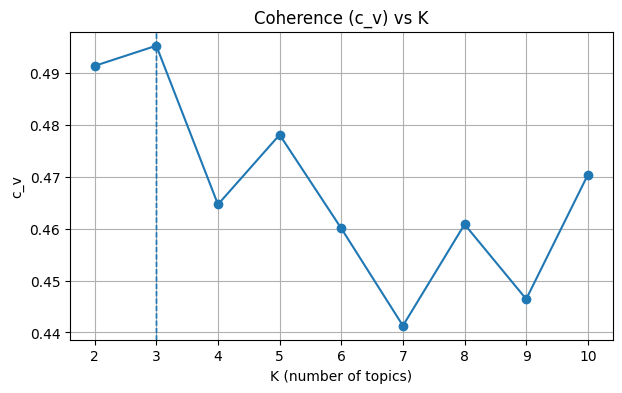

Saved: /content/drive/MyDrive/Result_Colab/lda_u_mass_vs_k.png


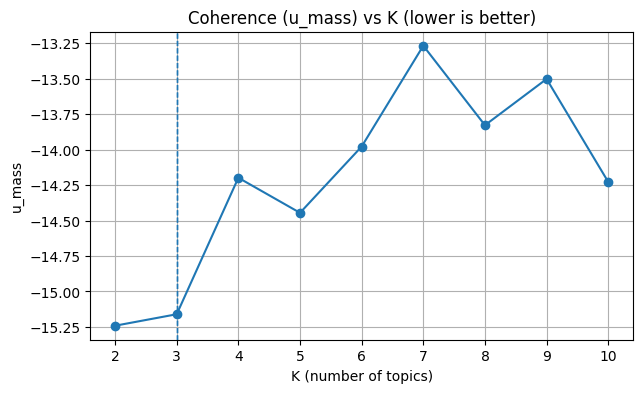

Saved: /content/drive/MyDrive/Result_Colab/lda_logppl_vs_k.png


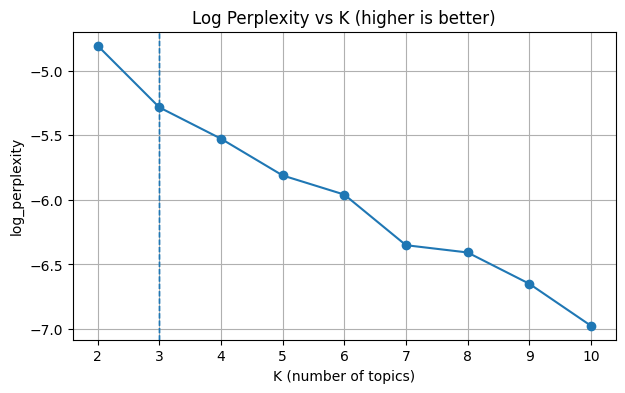

In [23]:
os.makedirs(RESULT_PATH, exist_ok=True)

# K with the highest c_v value (for reference)
k_cv_max = int(df_scores.loc[df_scores['c_v'].idxmax(), 'k'])
k_hint = 3  # Recommended K based on this dataset (adjust or remove if desired)

def _vline(k, xs):
    if xs.min() <= k <= xs.max():
        plt.axvline(k, linestyle='--', linewidth=1)

def plot_metric(df, ycol, title, ylabel, fname):
    xs = df['k'].values
    ys = df[ycol].values
    plt.figure(figsize=(7,4))
    plt.plot(xs, ys, marker='o')
    _vline(k_cv_max, df['k'])
    _vline(k_hint, df['k'])
    plt.title(title)
    plt.xlabel('K (number of topics)')
    plt.ylabel(ylabel)
    plt.grid(True)
    path = os.path.join(RESULT_PATH, fname)
    plt.savefig(path, bbox_inches='tight')
    print(f"Saved: {path}")
    plt.show()

# 1) c_v coherence — higher values indicate better topic coherence
plot_metric(df_scores, 'c_v', 'Coherence (c_v) vs K', 'c_v', 'lda_c_v_vs_k.png')

# 2) u_mass coherence — lower values indicate better topic quality
plot_metric(df_scores, 'u_mass', 'Coherence (u_mass) vs K (lower is better)', 'u_mass', 'lda_u_mass_vs_k.png')

# 3) Log Perplexity — higher (less negative) values indicate better generalization
plot_metric(df_scores, 'log_perplexity', 'Log Perplexity vs K (higher is better)', 'log_perplexity', 'lda_logppl_vs_k.png')

## Interpretation Tips
* **c_v / c_npmi / c_uci:** Higher values indicate better topic coherence.  
* **u_mass:** Lower values (usually negative) indicate better topic quality.  
* **log_perplexity:** Higher (less negative) values indicate better generalization.  
* In practice, choose the number of topics **K** where **c_v** reaches a peak  
  and **log_perplexity** does not deteriorate significantly — the so-called *“elbow point.”*

In [24]:
def topic_top_words(model, topn=15):
    """
    Return the top-N words for each topic of a trained LDA model.
    Parameters
    ----------
    model : gensim.models.LdaModel
        Trained LDA model.
    topn : int
        Number of top terms to extract per topic.
    Returns
    -------
    List[List[str]]
        A list where each element is the list of top terms for a topic.
    """
    topics = []
    for t in range(model.num_topics):
        terms = model.show_topic(t, topn=topn)
        topics.append([w for w, _ in terms])
    return topics

def avg_jaccard_over_topics(topics):
    """
    Compute the average Jaccard similarity across all pairs of topics.
    Lower values indicate less overlap (better topic distinctiveness).
    Parameters
    ----------
    topics : List[List[str]]
        List of topic term lists (e.g., output of topic_top_words()).
    Returns
    -------
    float
        Mean Jaccard similarity across topic pairs. Returns 0.0 if <2 topics.
    """
    from itertools import combinations
    sims, pairs = [], 0
    for a, b in combinations(topics, 2):
        A, B = set(a), set(b)
        j = len(A & B) / max(1, len(A | B))
        sims.append(j); pairs += 1
    return np.mean(sims) if pairs else 0.0

# Evaluate model coherence and perplexity for K=2–10
dup_rows = []
for k in range(K_MIN, K_MAX+1):
    # Fit an LDA model with K topics on the training corpus
    m = fit_lda(k, corpus_train, id2word, passes=PASSES, random_state=RANDOM_STATE)
    # Extract top terms per topic (use the same topn across K for fair comparison)
    topics = topic_top_words(m, topn=15)
    # Compute average Jaccard similarity (lower is better — fewer overlapping topics)
    dup_rows.append({'k': k, 'avg_jaccard': avg_jaccard_over_topics(topics)})

# Summarize redundancy scores by K
df_dup = pd.DataFrame(dup_rows)
print(df_dup)

    k  avg_jaccard
0   2     0.034483
1   3     0.034483
2   4     0.065727
3   5     0.077317
4   6     0.097560
5   7     0.126233
6   8     0.115672
7   9     0.133182
8  10     0.126616


When the number of topics is too high, similar or overlapping topics tend to appear.  
Prefer a value of **K** that minimizes redundancy, as measured by the **Jaccard similarity** between top words across topics.

Saved: /content/drive/MyDrive/Result_Colab/lda_avg_jaccard_vs_k.png


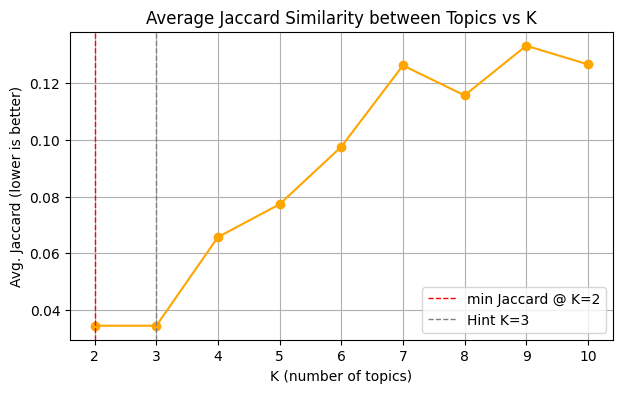

In [25]:
os.makedirs(RESULT_PATH, exist_ok=True)

# Models with lower Jaccard similarity indicate less redundancy (i.e., more distinct topics)
k_min_jaccard = int(df_dup.loc[df_dup['avg_jaccard'].idxmin(), 'k'])
k_hint = 3  # Empirical reference value for K (optional)

plt.figure(figsize=(7,4))
plt.plot(df_dup['k'], df_dup['avg_jaccard'], marker='o', color='orange')
plt.title('Average Jaccard Similarity between Topics vs K')
plt.xlabel('K (number of topics)')
plt.ylabel('Avg. Jaccard (lower is better)')
plt.grid(True)

# Draw vertical reference lines
plt.axvline(k_min_jaccard, linestyle='--', color='red', linewidth=1, label=f"min Jaccard @ K={k_min_jaccard}")
plt.axvline(k_hint, linestyle='--', color='gray', linewidth=1, label=f"Hint K={k_hint}")
plt.legend()

# Save the plot
path_jacc = os.path.join(RESULT_PATH, 'lda_avg_jaccard_vs_k.png')
plt.savefig(path_jacc, bbox_inches='tight')
print(f"Saved: {path_jacc}")

plt.show()

## Interpretation Tips
* Lower avg_jaccard → less overlap between topics (better model)
* Red dashed line = K with minimum Jaccard similarity
* Gray dashed line = empirically good value (e.g., K=3)
* If the curve rises gradually or shows an inflection, choose K near that region as the optimal number of topics
* Lower avg_jaccard → fewer overlapping top words between topics (less redundancy)
* If coherence scores are similar, prefer the model with lower avg_jaccard → it represents more distinct and interpretable topics.

#6. Topic Label Interpretation
* This step summarizes the dominant keywords.
* It helps evaluate whether the automatically labeled topics are semantically distinct.

In [26]:
os.makedirs(RESULT_PATH, exist_ok=True)

# 1) Train Word2Vec (for small corpora, min_count=1 is recommended)
w2v = Word2Vec(
    sentences=NN_words,
    vector_size=200,
    window=5,
    min_count=1,
    sg=1,              # skip-gram
    workers=2,
    seed=42
)

def _centroid(vecs, weights):
    """Compute a weighted centroid of vectors."""
    M = np.zeros_like(vecs[0])
    wsum = 0.0
    for v, w in zip(vecs, weights):
        M += v * w
        wsum += w
    return M / max(wsum, 1e-9)

def topic_top_terms(model, topn=15):
    """
    Return top-(topn) (term, weight) pairs for every topic of a trained LDA model.
    """
    topics = {}
    for t in range(model.num_topics):
        topics[t] = model.show_topic(t, topn=topn)  # list[(term, weight)]
    return topics

def auto_topic_label(model, w2v, term_to_tag=None, topn_terms=15):
    """
    Automatically select a single representative label per topic by combining:
      (1) top-N LDA terms for that topic (with their weights),
      (2) Word2Vec similarity to the topic's weighted centroid,
      (3) optional domain lexicon bonus (if term exists in term_to_tag).

    Returns
    -------
    dict[int, str]
        {topic_id: label_term}
    """
    topics = topic_top_terms(model, topn=topn_terms)
    labels = {}
    vocab = set(w2v.wv.index_to_key)

    for t, pairs in topics.items():
        # Keep only terms that exist in Word2Vec vocab
        terms   = [w for w, wt in pairs if w in vocab]
        weights = [wt for w, wt in pairs if w in vocab]

        # Compute topic centroid in embedding space
        center = None
        if terms:
            vecs = [w2v.wv[w] for w in terms]
            center = _centroid(vecs, weights)

        # Candidate pool = domain terms (if provided) + top LDA terms
        cand = []
        if term_to_tag:
            cand.extend([w for w in term_to_tag.keys() if w in vocab])
        cand.extend(terms)

        # Deduplicate and keep length >= 2
        seen = set()
        candidates = [c for c in cand if len(c) >= 2 and (c not in seen and not seen.add(c))]
        if not candidates:
            labels[t] = pairs[0][0] if pairs else f"Topic{t}"
            continue

        # Score = cosine(center, c) + LDA weight bonus + domain lexicon bonus
        scored = []
        for c in candidates:
            s = 0.0
            if center is not None and c in vocab:
                s += float(np.dot(center, w2v.wv[c]) / (np.linalg.norm(center) * np.linalg.norm(w2v.wv[c]) + 1e-9))
            # add LDA weight bonus if c is among top terms
            if c in [w for w, _ in pairs]:
                s += next(wt for w, wt in pairs if w == c)
            # add small domain bonus
            if term_to_tag and c in term_to_tag:
                s += 0.05
            scored.append((c, s))

        label = sorted(scored, key=lambda x: x[1], reverse=True)[0][0]
        labels[t] = label

    return labels

In [27]:
# 2) Generate labels for K=3 (assumes lda_bow was trained with NUM_TOPICS=3)
topic_labels = auto_topic_label(lda_bow, w2v, term_to_tag=TERM_TO_TAG, topn_terms=15)
print("Topic Labels (K=3):", topic_labels)

Topic Labels (K=3): {0: '로그인', 1: '인증', 2: '가입'}


In [28]:
# 3) Build a document-level dominant-topic report (with labels)
def doc_topic_report(model, corpus, texts, topn_words=10, labels=None):
    """
    Create a DataFrame with each document's dominant topic, probability, topic label, and previews.
    """
    rows = []
    topic_terms = {t: [w for w, _ in model.show_topic(t, topn=topn_words)]
                   for t in range(model.num_topics)}
    for i, bow in enumerate(corpus):
        dist = model.get_document_topics(bow, minimum_probability=0.0)
        dom_topic, dom_prob = max(dist, key=lambda x: x[1])
        rows.append({
            "doc_id": i,
            "dominant_topic": dom_topic,
            "topic_label": labels.get(dom_topic, f"Topic{dom_topic}") if labels else f"Topic{dom_topic}",
            "dominant_prob": round(dom_prob, 4),
            "top_terms_of_topic": ','.join(topic_terms[dom_topic]),
            "tokens_preview": ' '.join(texts[i][:20]),
        })
    return pd.DataFrame(rows)

df_dom = doc_topic_report(lda_bow, corpus, NN_words, topn_words=NUM_WORDS, labels=topic_labels)

# Save per-document dominant topic table
path_dom = os.path.join(RESULT_PATH, "lda_k3_dominant_topics.csv")
df_dom.to_csv(path_dom, index=False, encoding='utf-8-sig')
print("Saved:", path_dom)

Saved: /content/drive/MyDrive/Result_Colab/lda_k3_dominant_topics.csv


In [29]:
# 4) Topic-level summary (document count / top terms / label)
summary_rows = []
for t in range(lda_bow.num_topics):
    cnt = int((df_dom["dominant_topic"] == t).sum())
    terms = lda_bow.show_topic(t, topn=NUM_WORDS)
    summary_rows.append({
        "topic_id": t,
        "topic_label": topic_labels.get(t, f"Topic{t}"),
        "doc_count": cnt,
        "top_terms": ','.join([w for w, _ in terms])
    })
df_summary = pd.DataFrame(summary_rows).sort_values("doc_count", ascending=False)

path_sum = os.path.join(RESULT_PATH, "lda_k3_topic_summary.csv")
df_summary.to_csv(path_sum, index=False, encoding='utf-8-sig')
print("Saved:", path_sum)

Saved: /content/drive/MyDrive/Result_Colab/lda_k3_topic_summary.csv


In [30]:
# 5) (Optional) Save per-topic document subsets
for t in range(lda_bow.num_topics):
    df_t = df_dom[df_dom["dominant_topic"] == t].copy()
    out_t = os.path.join(RESULT_PATH, f"lda_k3_topic{t}_{topic_labels.get(t, f'Topic{t}')}.csv")
    df_t.to_csv(out_t, index=False, encoding='utf-8-sig')
    print("Saved:", out_t)

Saved: /content/drive/MyDrive/Result_Colab/lda_k3_topic0_로그인.csv
Saved: /content/drive/MyDrive/Result_Colab/lda_k3_topic1_인증.csv
Saved: /content/drive/MyDrive/Result_Colab/lda_k3_topic2_가입.csv
